In [2]:
import numpy as np
import numpy.random as rand
import matplotlib
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
from numpy import linalg as LA
#from cmaps import nice_cmap
from matplotlib.legend_handler import HandlerLine2D
import math
%matplotlib inline

In [73]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    out = np.array([rho, phi])
    return out.T

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    out = np.array([x, y])
    return out.T

def rand_vec(N, const_len=True, leng=1, var=0.1):
    if const_len:
        angle = 2*np.pi*rand.rand(N)
        angle.sort()
        points = leng*np.array([np.cos(angle),np.sin(angle)])
    else:
        angle = 2*np.pi*rand.rand(N)
        angle.sort()
        rlen = var*leng*rand.randn(N)+leng
        points = rlen*np.array([np.cos(angle),np.sin(angle)])
    return points

#If x1=0 then take (1,0,0,…),
#Else if x1 is non-zero and x2=0 then take (0,1,0,0,…),
#Else (x1 and x2 are non-zero) then take (−x2,x1,0,0,…).

def orth(v):
    if v.size<2:
        raise ValueError('Vector has less than 2 dims.')
    if not np.any(v):
        raise ValueError('Zero vector.')
    if v[0]==0:
        return np.eye(v.size)[:,0]
    elif v[1]==0:
        return np.eye(v.size)[:,1]
    else:
        return -v[1]*np.eye(v.size)[:,0] + v[0]*np.eye(v.size)[:,1]

In [5]:
from scipy.spatial import ConvexHull
from matplotlib import path

poly_path = path.Path([[0 ,0],[0,0]])

def in_hull(p, points):
    global poly_path
    points = np.vstack((points, points[0,:]))
    poly_path = path.Path(points)
    if poly_path.contains_point(p, radius=0.01):
        return True
    else:
        return False
    
def dis(point1, point2):
    return np.dot((point1-point2),(point1-point2))

def convex(points): ##(N,2)
    midpoints = []
    delete_index = []
    for ind1,point in enumerate(points):
        for ind2,other_point in enumerate(points):
            if ind1<ind2:
                midp = (point + other_point )/2
                print(ind1, ind2,in_hull(midp, points))
                midpoint = np.hstack((midp, np.array(in_hull(midp, points))))
                if not in_hull(midp, points):
                    sum_dis1 = 0.
                    for supoint in points:
                        sum_dis1 += dis(supoint, point)
                    sum_dis1 /= points.shape[0]
                    sum_dis2 = 0.
                    for supoint in points:
                        sum_dis2 += dis(supoint, other_point)
                    sum_dis2 /= points.shape[0]
                    if sum_dis1 > sum_dis2:
                        delete_index.append(ind1)
                        print("deleted", ind1)
                    else:
                        delete_index.append(ind2)
                        print("deleted", ind2)
                midpoints.append(midp)
    midpoints = np.array(midpoints)
    outpoints = np.array([p for i,p in enumerate(points) if i not in delete_index])
    print(outpoints.shape)
    return outpoints
                    

In [6]:
from matplotlib import lines as mpl_lines

def slope_from_points(point1, point2):
    if (point2[0] - point1[0]) == 0:
        return np.nan
    return (point2[1] - point1[1])/(point2[0] - point1[0])

def plot_secant(index, point1, point2, ax):
    color = ["red", "yellow", "blue"]
    # plot the secant
    slope = slope_from_points(point1, point2)
    if not np.isnan(slope):
        intercept = point1[1] - slope*point1[0] 
        # update the points to be on the axes limits
        x = ax.get_xlim()
        y = ax.get_ylim()
        data_y = [x[0]*slope+intercept, x[1]*slope+intercept]
        line = mpl_lines.Line2D(x, data_y, ls='--',lw=0.2)
    else:
        intercept = point2[0]
        x = [point2[0], point1[0]]
        y = ax.get_ylim()
        line = mpl_lines.Line2D(x, y, ls='--', lw=0.2)
    ax.add_line(line)
    return [ax, slope, intercept]

In [ ]:
#### NOT USED NOW
def ccw(A,B,C):
    return (C[1]-A[1])*(B[0]-A[0]) > (B[1]-A[1])*(C[0]-A[0])

def intersect(A,B,C,D):
        if ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D):
            if (A[0]-B[0]) == 0:
                n = (C[1]-D[1])/(C[0]-D[0])
                a = C[1] - n*C[0]
                return np.array([A[0], n*A[0]+a])
            elif (C[0]-D[0]) == 0:
                m = (A[1]-B[1])/(A[0]-B[0])
                b =  A[1] - n*A[0]
                return np.array([C[0], m*C[0]+b])
            else:
                n = (C[1]-D[1])/(C[0]-D[0])
                a = C[1] - n*C[0]
                m = (A[1]-B[1])/(A[0]-B[0])
                b =  A[1] - n*A[0]
                px = (a-b)/(m-n)
                return np.array([px, m*px+b])
        else:
            return None
                
M = 2
N = 6
RANDOM = True
if RANDOM:
    D = rand_vec(N, False,1.)
else:
    angles = np.linspace(0, 2*np.pi, num=N, endpoint=False)
    angles[1] +=np.pi/8
    D = np.array([np.cos(angles),np.sin(angles)])
rmax = np.max(np.sqrt(D[0,:]**2+D[1,:]**2))
all_weights=[]
all_weights.append(D)

In [7]:
def intersect_line(line1,line2):
    if np.isnan(line1[0]) and np.isnan(line2[0]):
        return [np.nan, np.nan]
    elif np.isnan(line1[0]):
        p = line1[1]
        n = line2[0]
        a = line2[1]
        y = n*p+a
        v = [ round(p, 6), round(y, 6) ]
    elif np.isnan(line2[0]):
        p = line2[1]
        n = np.round(line1[0], decimals=6)
        a = line1[1]
        y = n*p+a
        v = [ round(p, 6), round(y, 6) ]
    else:
        r = np.round(line1[0]-line2[0], decimals=6)
        if r != 0:
            p = (line2[1]-line1[1])/r
            n = line1[0]
            a = line1[1]
            y = n*p+a
            v = [ round(p,6), round(y, 6) ]
        else:
            v = [np.nan, np.nan]
    return v

# Compute intersections of threshold boundaries

In [68]:
def normal(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = normal(v1)
    v2_u = normal(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def lindis(vec1, vec2):
    " Returns linear distance "
    return (vec2[:,0]-vec1[:,0]) + (vec2[:,0]-vec1[:,0])

def find_nearest(vector):
    " Returns indices of nearest points "
    a_masked = np.ma.masked_array(vector)
    a_masked[vector < 0] = np.ma.masked
    pos = a_masked.argmin()
    a_masked = np.ma.masked_array(vector)
    a_masked[vector > 0] = np.ma.masked
    neg = a_masked.argmax()
    return np.array([neg, pos])

def intersects(secants): 
    N = secants.shape[0]
    sects = []
    
    " find all intersections and lines connected "
    for i in range(N):
        temp_sects = []
        for j in range(i):
            temp_sects.append(intersect_line(secants[i,:], secants[j,:]))
            if not np.any(np.isnan(temp_sects[-1])):
                sects.append((temp_sects[-1][0], temp_sects[-1][1]))
                
    
    sects = np.array(sects)
    sects = np.array(sorted(sects, key=lambda x: np.arctan2(x[1],x[0])))
    #print(sects)
    ncon = int(len(sects))
    sectconn = np.zeros((ncon,ncon))
    #print(sectconn)
    
    " find most inner loop of intersections "
    inner = []
    selected = []
    if ncon > M:
        # 0) initial point: minimum distance to origin
        distance = sects[:,0]**2 + sects[:,1]**2
        cur_sect = np.argmin(distance)
        #print("Nearest intersect:", cur_sect)
        inner.append(sects[cur_sect])
        selected.append(cur_sect)
        connectors = sectconn[cur_sect]
        
        #while loop:
        # 1) find connected intersections (that are not already in loop) 
        #    and take the one that has minimum distance to origin
        #print("connectors:", connectors)
        #print("non-zeros:",np.nonzero(connectors)[0])
        #for ind in np.nonzero(connectors)[0]:
        #    cur_sect = np.nanargmin(distance*connectors)
        #    if cur_sect not in selected:
        #        O = np.array([0, 0])
        #        avec = inner[-1]
        #        bvec = 
        #        inner.append(sects[cur_sect])
        #        selected.append(cur_sect)
        #        connectors = sectconn[cur_sect]
        
    inner = np.array(inner)
    #print(inner)
    return sects

# Plot inner polytope 

In [223]:
from matplotlib.patches import Circle, Polygon, PathPatch

def polytope_axis(ind, ax, D, title):
    N = D.shape[1]
    col = plt.get_cmap('rainbow', N)
    rmax = np.max(np.sqrt(D[0,:]**2+D[1,:]**2))
    circle = Circle((0, 0), rmax, facecolor='none', edgecolor=(0, 0.1, 0.1), linewidth=1, alpha=0.5)
    ax.add_patch(circle)
    ax.plot(0, 0, '+')
    def_scale = 1.5
    ax.set_xlim([-def_scale,def_scale])
    ax.set_ylim([-def_scale,def_scale])

    arrow_sc= 0.05
    secants = []
    for i in range(N):
        orthD = orth(D[:,i])
        if np.sqrt(D[0,i]**2 + D[1,i]**2) > 0.:
            ax.arrow(0, 0, D[0,i], D[1,i], width=rmax*arrow_sc/5, head_width=rmax*arrow_sc, head_length=rmax*arrow_sc, lw=0.5, length_includes_head=True, fc=col(i), ec=col(i))
        secants.append(plot_secant(i, 0.5*D[:,i], 0.5*D[:,i]+0.1*orthD, ax))
        ax = secants[-1][0]
    
    ## Calculate polygon
    secants = np.array(secants)
    secants = secants[:,1:]
    sects = intersects(secants)
    #if ind == 1:
        #sects = np.delete(sects, (2,4), axis=0)
    #if ind < 3:
    #    polygon = Polygon(sects, True, ec=None, fc="#ff1111", alpha=0.02)
    #    ax.add_patch(polygon)
    zero = np.array([0.,0.])
    hull = sects
    #print("In convex hull:", in_hull(zero, hull))
    #ax.axis('equal')
    ax.axis('off')
    ax.text(-def_scale/3, def_scale,title, fontsize=16)
    return ax, sects

def plot_polytope(weights, titles):
    figs = len(weights)
    #print(figs)
    figsiz = (figs*4, 5)
    if figs == 1:
        figsiz = (4,4)
    f, axarr = plt.subplots(1,figs, figsize=figsiz, sharex=True, sharey=True)
    if figs==1:
        axarr, sect = polytope_axis(0, axarr, weights[0], titles[0])
    else:
        for ind, ax in enumerate(axarr):
            print("Figure", ind)
            ax, sect = polytope_axis(ind, ax, weights[ind], titles[ind])
            ax.set(adjustable='box-forced', aspect='equal')
            print()
            
    return f, axarr, sect

Figure 0

Figure 1

Figure 2

Figure 3



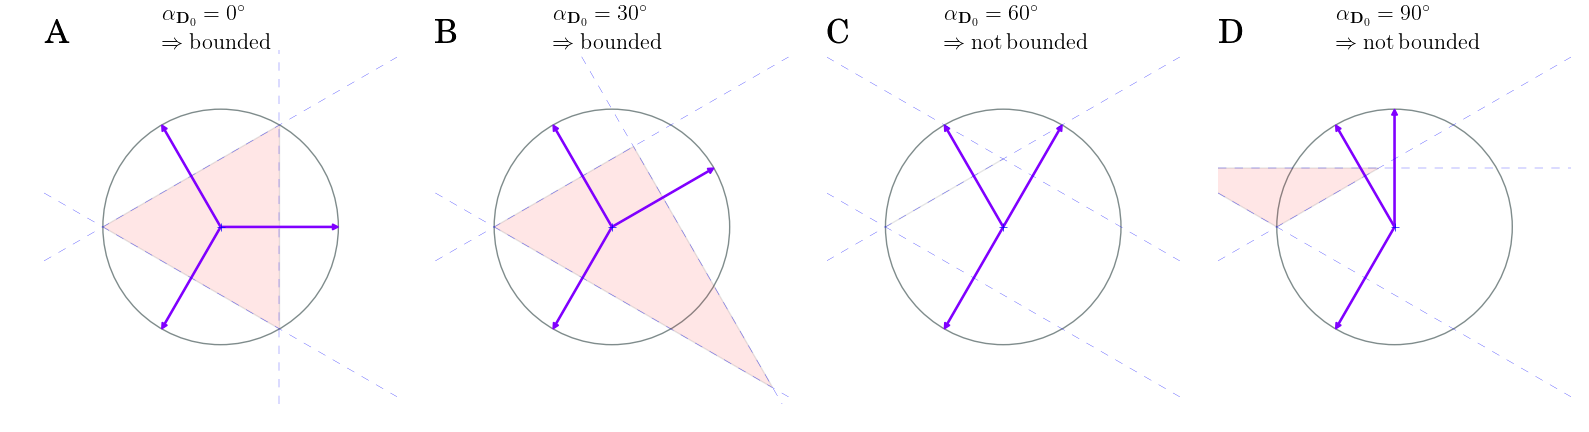

In [138]:
titles = ["$\\alpha_{\mathbf{D}_0}=0^{\circ}$\n $\Rightarrow \mathrm{bounded}$",
          "$\\alpha_{\mathbf{D}_0}=30^{\circ}$\n $\Rightarrow \mathrm{bounded}$",
          "$\\alpha_{\mathbf{D}_0}=60^{\circ}$ \n $\Rightarrow \mathrm{not\,bounded}$",
          "$\\alpha_{\mathbf{D}_0}=90^{\circ}$\n $\Rightarrow \mathrm{not\,bounded}$"]
all_weights = []
N = 3
figs = 4

for i in range(figs):
    angles = np.linspace(0, 2*np.pi, num=N, endpoint=False)
    angles[0] += i*np.pi/6
    D = np.array([np.cos(angles),np.sin(angles)])
    all_weights.append(D)
fig, ax, sects = plot_polytope(all_weights,titles)
panel = ["A","B","C","D","E","F"]
for i in range(figs):
    ax[i].set_title(panel[i], fontsize=figs*6, loc='left')
plt.subplots_adjust(wspace=0.1)
plt.tight_layout()
plt.draw()
#fig.savefig("./plots/2simplex.pdf", dpi=900)
plt.show()

Figure 0

Figure 1

Figure 2

Figure 3



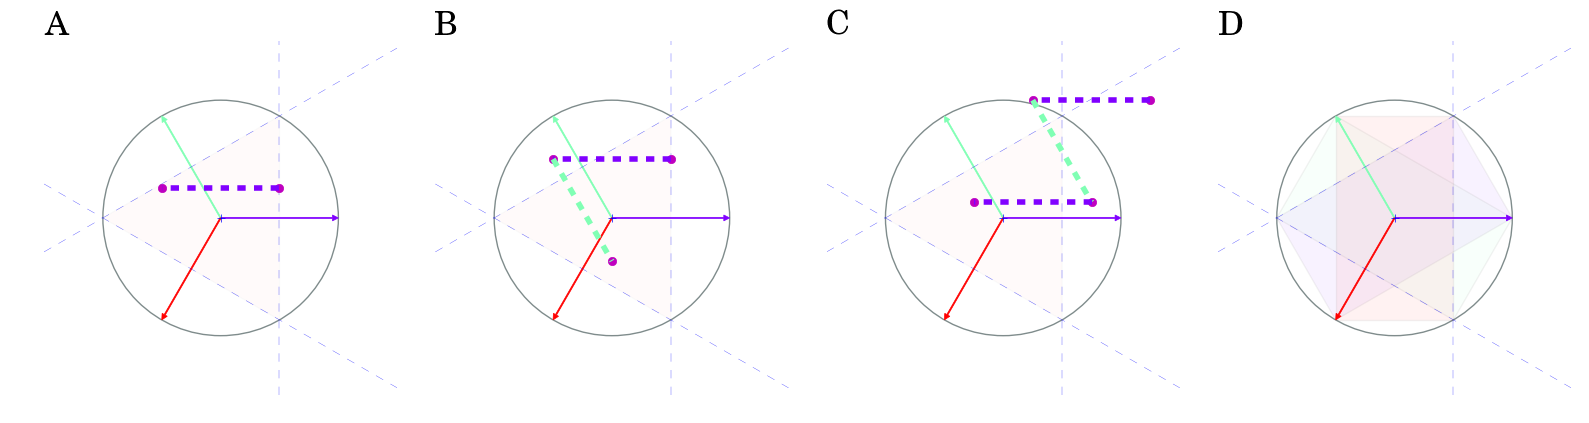

In [219]:
from matplotlib.patches import Rectangle
N = 3
figs = 4
titles = [""]*figs
all_weights = []

for i in range(figs):
    angles = np.linspace(0, 2*np.pi, num=N, endpoint=False)
    D = np.array([np.cos(angles),np.sin(angles)])
    all_weights.append(D)
fig, ax, sects = plot_polytope(all_weights,titles)
panel = ["A","B","C","D","E","F"]
if figs > 1:
    for i in range(figs):
        ax[i].set_title(panel[i], fontsize=figs*6, loc='left')

#print(sects, D)
for ind in range(len(sects)):
    rect = np.zeros((4,2))
    rect[0,:] = sects[ind-1,:]
    rect[1,:] = sects[ind,:]
    rect[2,:] = sects[ind,:]-D[:,ind-2]
    rect[3,:] = sects[ind-1,:]-D[:,ind-2]
    rects = Polygon(rect, True, ec=None, fc=col(ind), alpha=0.05)
    ax[3].add_patch(rects)
x=[0.5,-D[0,0]]
y=[0.25,-D[1,0]]
ax[0].plot(np.cumsum(x),np.cumsum(y),"o",mec="m", mfc="m", c= "m")
ax[0].plot(np.cumsum(x),np.cumsum(y),"--", c= col(0), lw=4)
x=[0.5,-D[0,0],-D[0,1]]
y=[0.5,-D[1,0],-D[1,1]]
ax[1].plot(np.cumsum(x),np.cumsum(y),"o",mec="m", mfc="m", c= "m")
ax[1].plot(np.cumsum(x[0:2]),np.cumsum(y[0:2]),"--", c= col(0), lw=4)
ax[1].plot(np.cumsum(x)[1:],np.cumsum(y)[1:],"--", c= col(1), lw=4)
x=[1.25,-D[0,0],-D[0,1],-D[0,0]]
y=[1,-D[1,0],-D[1,1],-D[1,0]]
ax[2].plot(np.cumsum(x),np.cumsum(y),"o",mec="m", mfc="m", c= "m")
ax[2].plot(np.cumsum(x)[0:2],np.cumsum(y)[0:2],"--", c= col(0), lw=4)
ax[2].plot(np.cumsum(x)[1:3],np.cumsum(y)[1:3],"--", c= col(1), lw=4)
ax[2].plot(np.cumsum(x)[2:],np.cumsum(y)[2:],"--", c= col(0), lw=4)
    #ax.arrow(1, 1, D[0,i], D[1,i], width=rmax*arrow_sc/5, head_width=rmax*arrow_sc, head_length=rmax*arrow_sc, lw=0.5, length_includes_head=True, fc=col(i), ec=col(i))
    #ax.plot([sects[ind,0], sects[ind,0]-D[0,inds[0]]/2], [sects[ind,1],sects[ind,1]-D[1,inds[0]]/2], "g-")
    #ax.plot([sects[0,0], sects[0,0]], [sects[0,1],sects[0,1]], "g*")

plt.subplots_adjust(wspace=0.1)
plt.tight_layout()
plt.draw()
#fig.savefig("./plots/doublespike.pdf", dpi=900)
plt.show()

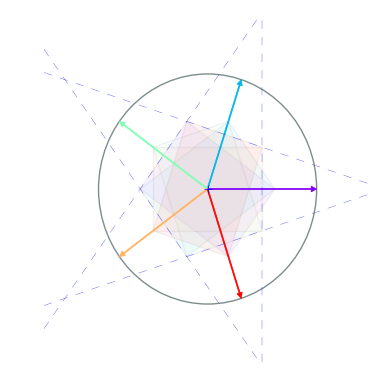

In [239]:
from matplotlib.patches import Rectangle
N = [5]
figs = 1
titles = [""]*figs
all_weights = []

for i in range(figs):
    col = plt.get_cmap('rainbow', N[i])
    angles = np.linspace(0, 2*np.pi, num=N[i], endpoint=False)
    D = np.array([np.cos(angles),np.sin(angles)])
    all_weights.append(D)
fig, ax, sects = plot_polytope(all_weights,titles)
panel = ["A","B","C","D","E","F"]
if figs > 1:
    for i in range(figs):
        ax[i].set_title(panel[i], fontsize=figs*6, loc='left')

#print(sects, D)
inds = []
for ind in range(N[0]):
    rect = np.zeros((4,2))
    rect[0,:] = sects[2*ind,:]
    rect[1,:] = sects[2*ind-2,:]
    rect[2,:] = sects[2*ind-2,:]-D[:,ind-3]
    rect[3,:] = sects[2*ind,:]-D[:,ind-3]
    rects = Polygon(rect, True, ec=None, fc=col(ind), alpha=0.05)
    ax.add_patch(rects)

plt.subplots_adjust(wspace=0.1)
plt.tight_layout()
plt.draw()
fig.savefig("./plots/5.pdf", dpi=900)
plt.show()

Figure 0

Figure 1

Figure 2



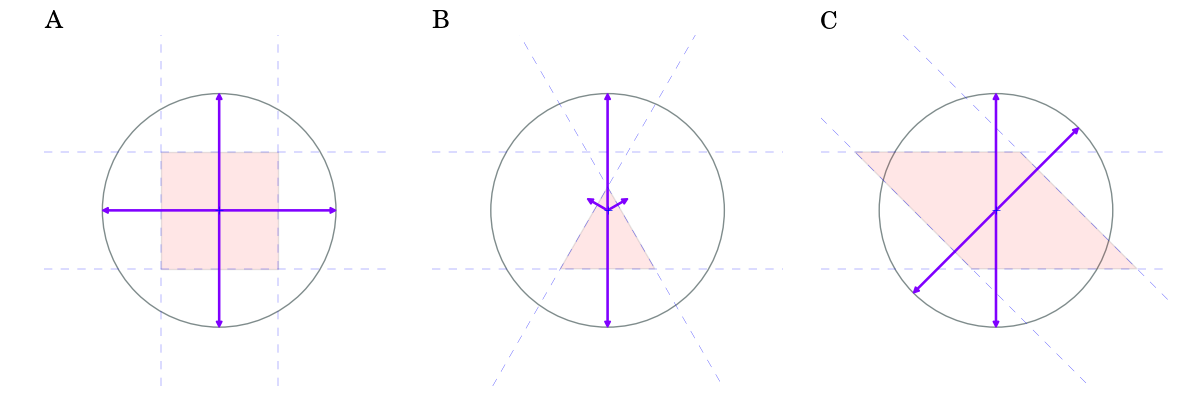

In [125]:
titles = ["",
          "",
          ""]
all_weights = []
M = 2
N = 4
figs = 3

for i in range(figs):
    angles = np.linspace(0, 2*np.pi, num=N, endpoint=False)
    if i==1:
        angles[0] += np.pi/6
        angles[2] -= np.pi/6
    if i==2:
        angles[0] += np.pi/4
        angles[2] += np.pi/4
    if i==3:
        D = rand_vec(1000, False, 1., .05)
    else:
        D = np.array([np.cos(angles),np.sin(angles)])
    
    if i==1:
        D[:,0]*=0.2
        D[:,2]*=0.2
    
    all_weights.append(D)
    
fig, ax = plot_polytope(all_weights,titles)
panel = ["A","B","C","D","E","F"]
for i in range(figs):
    ax[i].set_title(panel[i], fontsize=figs*6, loc='left')
plt.subplots_adjust(wspace=0.1)
plt.tight_layout()
plt.draw()
#fig.savefig("./plots/rect.pdf", dpi=900)
plt.show()

Figure 0

Figure 1

Figure 2



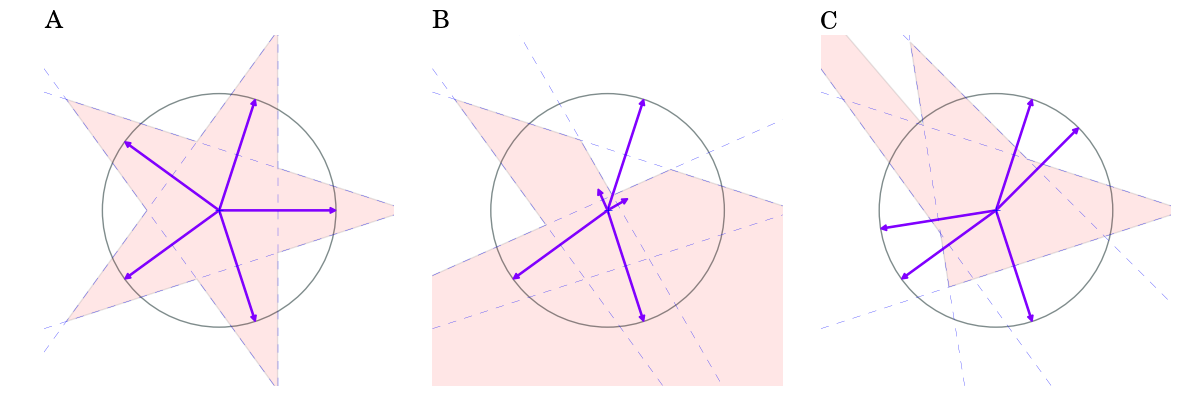

In [124]:
titles = ["",
          "",
          ""]
all_weights = []
M = 2
N = 5
figs = 3

for i in range(figs):
    angles = np.linspace(0, 2*np.pi, num=N, endpoint=False)
    if i==1:
        angles[0] += np.pi/6
        angles[2] -= np.pi/6
    if i==2:
        angles[0] += np.pi/4
        angles[2] += np.pi/4
    if i==3:
        D = rand_vec(1000, False, 1., .05)
    else:
        D = np.array([np.cos(angles),np.sin(angles)])
    
    if i==1:
        D[:,0]*=0.2
        D[:,2]*=0.2
    
    all_weights.append(D)
    
fig, ax = plot_polytope(all_weights,titles)
panel = ["A","B","C","D","E","F"]
for i in range(figs):
    ax[i].set_title(panel[i], fontsize=figs*6, loc='left')
plt.subplots_adjust(wspace=0.1)
plt.tight_layout()
plt.draw()
fig.savefig("./plots/more.pdf", dpi=900)
plt.show()